# Gameplan

To get different particle numbers at the same couplings, I will increment different solutions simultaneously! Woah that's crazy.

In [1]:
from solve_rg_eqs import *
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


l = 8
print('Ns:')
Ns = np.arange(4, 4*l-2, 2)
print(Ns)
k = np.arange(1, 2*l+1, 2)*0.5*np.pi/l
Gc = 1./np.sum(k)
dg = 0.01/Ns[-1]
g0 = .1*dg
imk = g0
imv = .1*g0

gs = np.arange(g0, G_to_g(.3*Gc, k), dg)
qs = np.arange(1/gs[-1], 1/G_to_g(1.2*Gc, k), -10*dg)
print(len(gs))
print(len(qs))

Ns:
[ 4  6  8 10 12 14 16 18 20 22 24 26 28]
96
8831


In [2]:
def bootstrap_g0_multi(L, g0, kc, imscale_v):
    vs = np.zeros(L)

    vars = g0_guess(L, 2, 2, kc, g0, imscale=imscale_v)
    er = 10**-6
    Ns = np.arange(4, 4*L, 2)
    Ne = Ns[-1]//2
    sols = [None for N in Ns]
    for i, N in enumerate(Ns):
        log('')
        log('Now using {} fermions'.format(N))
        log('')
        n = N//2
        dims = (L, n, n)
        print('Dimensions')
        print(dims)
        # Solving for 2n fermions using extrapolation from previous solution
        if n == 2:
            force_gs=False
            noise_factors=None
        else:
            # The previous solution matches to roughly the accuracy of the solution
            # for the shared variables
            noise_factors = 10*er*np.ones(len(vars))
            # But we will still need to try random stuff for the 4 new variables
            noise_factors[n-2:n] = 1
            noise_factors[2*n-2:2*n] = 1
            noise_factors[3*n-2:3*n] = 1
            noise_factors[4*n-2:4*n] = 1
        sol = find_root_multithread(vars, kc, g0, dims, imscale_v,
                                    max_steps=MAX_STEPS_1,
                                    use_k_guess=False,
                                    noise_factors=noise_factors,
                                    force_gs=force_gs,
                                    factor=1.4)
        print(vars)
        vars = sol.x
        er = max(abs(rgEqs(vars, kc, g0, dims)))
        log('Error with {} fermions: {}'.format(2*n, er))
        sols[i] = sol
        
        if n%2 == 1:
            # setting up for N divisible by 4 next step
            vars = sols[i-1].x # Better to start from last similar case
            n -= 1
            incr = 2
        else:
            incr = 1
        es, ws = unpack_vars(vars, n, n)
        vars_guess = g0_guess(L, n+incr, n+incr, kc, g0, imscale=imscale_v)
        esg, wsg = unpack_vars(vars_guess, n+incr, n+incr)
        es = np.append(es, esg[-incr:])
        ws = np.append(ws, wsg[-incr:])
        vars = pack_vars(es, ws)        

    return sols, Ns

In [3]:
kc = np.concatenate((k, (-imk)**np.arange(l)))

Ns = np.arange(4, 4*l, 2)
prev_sols = [None for N in Ns]
energies = np.zeros((len(gs), len(Ns)))
ers = np.zeros((len(gs), len(Ns)))
for gi, g in enumerate(gs):
    print('')
    if g == gs[0]:
        prev_sols, Ns = bootstrap_g0_multi(l, g, kc, imscale_v=imv)
    else:
        for Ni, N in enumerate(Ns):
            prev_vars = prev_sols[Ni].x
            # print(prev_vars)
            dims = (l, N//2, N//2)
            sol = root(rgEqs, prev_vars, args=(kc, g, dims))
            er = np.max(np.abs(sol.fun))
            print('Error at g = {} with {} fermions'.format(np.round(g,4), N))
            print(er)
            prev_sols[Ni] = sol
            varss = np.transpose(np.array([sol.x]))
            energy, _ = calculate_energies(dims, [g], k, varss)
            energies[gi, Ni] = energy[0]
            ers[gi, Ni] = er
    



Now using 4 fermions

Dimensions
(8, 2, 2)
Bad initial guess. Trying with noise.
g = 3.571428571428572e-05, er = 0.0015654219080826887
1th try at g = 3.571428571428572e-05
Smallest error from last set: 0.0015654219080826887
Noise ranges from -2.563144315000614e-06 to 4.86899643388261e-06
3th try at g = 3.571428571428572e-05
Smallest error from last set: 0.0007518926219284435
Noise ranges from -3.9733502535693084e-06 to 5.067921832621938e-06
5th try at g = 3.571428571428572e-05
Smallest error from last set: 0.0008842981979688235
Noise ranges from -6.525159501324971e-06 to 2.3063326733347416e-06
7th try at g = 3.571428571428572e-05
Smallest error from last set: 0.0012177819319629855
Noise ranges from -9.235375752514876e-06 to 8.504193692583255e-06
9th try at g = 3.571428571428572e-05
Smallest error from last set: 0.0007619443626808789
Noise ranges from -1.546099270065624e-05 to 4.14940679765967e-06
11th try at g = 3.571428571428572e-05
Smallest error from last set: 0.000999995352578540

/Users/wholdhus/Desktop/repos/so5-richardson-gaudin/utils.py:13: RuntimeWarning: overflow encountered in multiply
  return ((x*u-y*v)*(x-u)+(y*u+x*v)*(y-v))/((x-u)**2+(y-v)**2)
/Users/wholdhus/Desktop/repos/so5-richardson-gaudin/utils.py:13: RuntimeWarning: overflow encountered in square
  return ((x*u-y*v)*(x-u)+(y*u+x*v)*(y-v))/((x-u)**2+(y-v)**2)
/Users/wholdhus/Desktop/repos/so5-richardson-gaudin/utils.py:13: RuntimeWarning: invalid value encountered in true_divide
  return ((x*u-y*v)*(x-u)+(y*u+x*v)*(y-v))/((x-u)**2+(y-v)**2)
/Users/wholdhus/Desktop/repos/so5-richardson-gaudin/utils.py:16: RuntimeWarning: overflow encountered in multiply
  return ((x*u-y*v)*(v-y)+(y*u+x*v)*(x-u))/((x-u)**2+(y-v)**2)
/Users/wholdhus/Desktop/repos/so5-richardson-gaudin/utils.py:16: RuntimeWarning: overflow encountered in square
  return ((x*u-y*v)*(v-y)+(y*u+x*v)*(x-u))/((x-u)**2+(y-v)**2)
/Users/wholdhus/Desktop/repos/so5-richardson-gaudin/utils.py:16: RuntimeWarning: invalid value encountered in t


5.340250886831654e-08
Calculating R_k, energy
Error at g = 0.0022 with 14 fermions
1.6061207741862356e-07
Calculating R_k, energy
Error at g = 0.0022 with 16 fermions
6.2656410173238845e-09
Calculating R_k, energy
Error at g = 0.0022 with 18 fermions
3.628253755648205e-08
Calculating R_k, energy
Error at g = 0.0022 with 20 fermions
1.5710151065003887e-08
Calculating R_k, energy
Error at g = 0.0022 with 22 fermions
6.087075379720578e-08
Calculating R_k, energy
Error at g = 0.0022 with 24 fermions
3.205693100889156e-08
Calculating R_k, energy
Error at g = 0.0022 with 26 fermions
7.499775553096048e-08
Calculating R_k, energy
Error at g = 0.0022 with 28 fermions
4.761500461013059e-08
Calculating R_k, energy
Error at g = 0.0022 with 30 fermions
1.3152534339561887e-07
Calculating R_k, energy

Error at g = 0.0025 with 4 fermions
5.9188602024188135e-09
Calculating R_k, energy
Error at g = 0.0025 with 6 fermions
0.3921568610731136
Calculating R_k, energy
Error at g = 0.0025 with 8 fermions
9.7

14
[ 4  6  8 10 12 14 16 18 20 22 24 26 28 30]


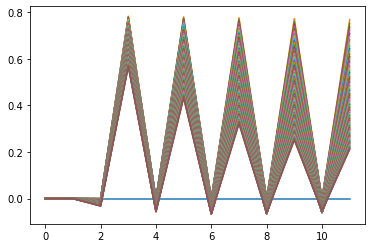

In [6]:
Gs = g_to_G(gs, k)

print(2*l-2)
print(Ns)
Gi = 10
gaps = np.zeros(2*l-4)
for Gi in range(len(Gs)):
    for i in range(2*l-4):
        if np.max(ers[Gi, i:i+2]) < 10**-6:
            eN = energies[Gi, i+1] 
            eNm1 = energies[Gi, i]
            eNp1 = energies[Gi, i+2]
            gaps[i] = eNp1 + eNm1 - 2*eN
    plt.plot(gaps)